## Overview

In this homework assignment, you are a data scientist working for the U.S. federal government. Due to budget cuts for education, your office has been tasked with cutting federal funding to some number of school districts. Your supervisor has asked you to develop a recommendation and objective justification for their decision using data analysis.

Due to related budget cuts, the most recent fiscal data you have to work with is from 2015-16. Download the 2015-16 district-level fiscal data from the National Center for Education Statistics’ Common Core of Data:
• https://nces.ed.gov/ccd/f33agency.asp

For helping you make your decision, it may be helpful to have some performance metrics for each district. You can download the 2015-16 data for distrct-level statistics on graduation rate and state assessments on mathematics and reading/language arts from the EDFacts website:
• https://www2.ed.gov/about/inits/ed/edfacts/data-files/index.html

These datasets can be linked based on the LEA IDs.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

%matplotlib inline

In [2]:
def load_data():
    fiscal_df = pd.read_csv('../input/Sdf16_1a.txt', sep='\t')
    math_df = pd.read_csv('../input//math-achievement-lea-sy2015-16.csv')
    arts_df = pd.read_csv('../input/rla-achievement-lea-sy2015-16.csv')
    return fiscal_df, math_df, arts_df

In [3]:
fiscal_df, math_df, arts_df = load_data()
fiscal_df = fiscal_df[fiscal_df['TFEDREV']>0]

/Users/karangm/PycharmProjects/ds5500-hw3/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/karangm/PycharmProjects/ds5500-hw3/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/karangm/PycharmProjects/ds5500-hw3/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (17,45,129,143) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Problem 1
Import and explore the district-level fiscal data from 2015-16. Rank and visualize the states that take in the most federal funding (revenue). Which states spend the most federal funding per student?

In [4]:
def most_federal_funding(fiscal_df):
    result_df = fiscal_df[['STNAME', 'TFEDREV']].groupby(['STNAME']).sum().sort_values(by='TFEDREV', ascending=False)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    sns.barplot(x=result_df.index, y="TFEDREV", data=result_df, ax=ax)
    ax.tick_params(labelrotation=90)
    ax.title.set_text('Federal Funding by States')
    fig.savefig('../output/1_1.png')
    plt.show()

In [5]:
def federal_expenditure(fiscal_df):
    result_df = fiscal_df[['STNAME', 'CE2', 'V33']].groupby(['STNAME']).sum()
    result_df['average_spend'] = result_df['CE2']/result_df['V33']
    result_df.sort_values(by='average_spend', ascending=False, inplace=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    sns.barplot(x=result_df.index, y="average_spend", data=result_df, ax=ax)
    ax.tick_params(labelrotation=90)
    ax.title.set_text('Federal Spend per student by States')
    fig.savefig('../output/1_2.png')
    plt.show()

In [6]:
def run_1(fiscal_df):
    most_federal_funding(fiscal_df)
    federal_expenditure(fiscal_df)

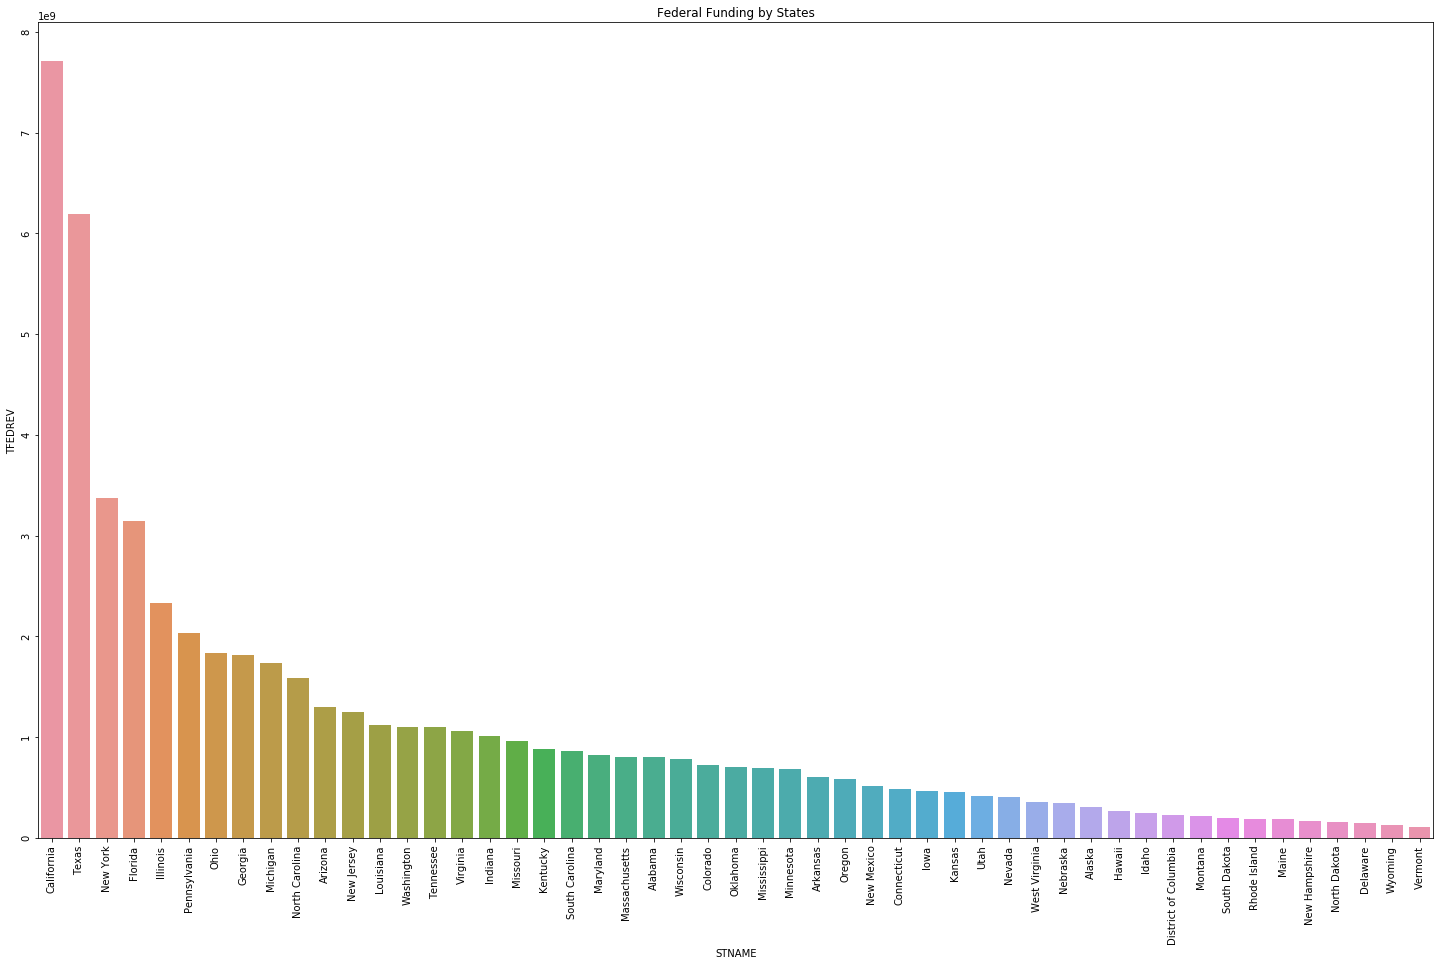

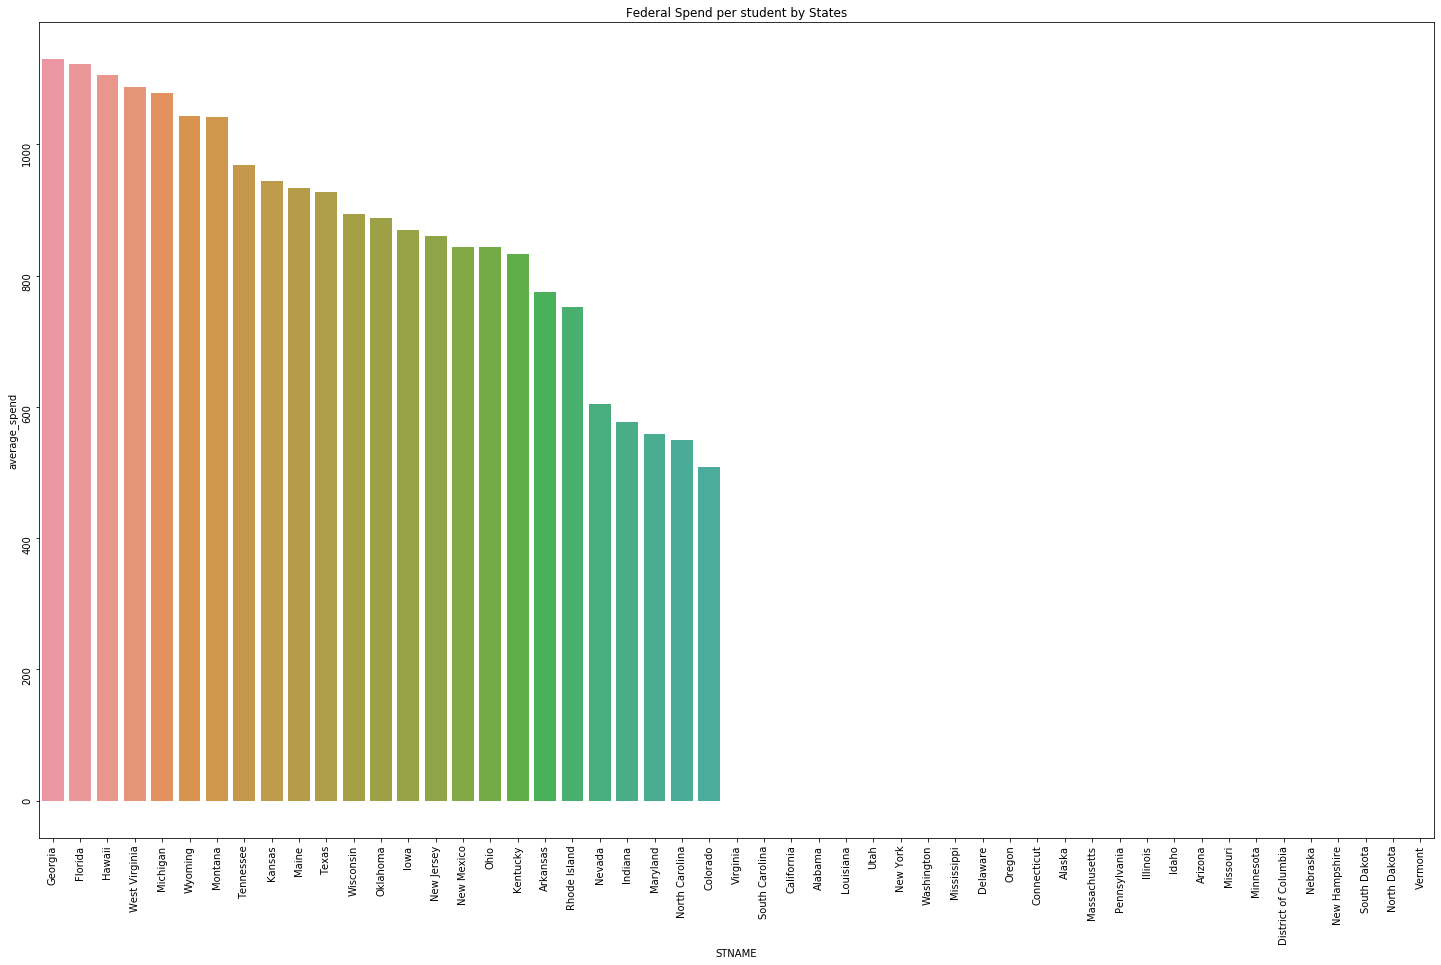

In [7]:
run_1(fiscal_df)

## Problem 2

Visualize the relationship between school districts’ total revenue and expenditures. Which states have the most debt per student?

In [9]:
def revenue_vs_expenditure_by_district(fiscal_df):
    result_df = fiscal_df[['NAME', 'TOTALREV', 'TOTALEXP']].groupby(['NAME']).sum()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    sns.scatterplot(x='TOTALREV', y='TOTALEXP', data=result_df, ax=ax)
    ax.title.set_text('Revenue vs Expenditure by district')
    fig.savefig('../output/2_1.png')
    plt.show()

In [10]:
def debt_per_student_by_district(fiscal_df):
    result_df = fiscal_df[['STNAME', '_41F', '_66V', 'V33']].groupby(['STNAME']).sum()
    result_df['debt_per_student'] = (result_df['_41F'] + result_df['_66V']) / result_df['V33']
    result_df.sort_values(by='debt_per_student', ascending=False, inplace=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    sns.barplot(x=result_df.index, y='debt_per_student', data=result_df, ax=ax)
    ax.tick_params(labelrotation=90)
    ax.title.set_text('Debt per student by state')
    fig.savefig('../output/2_2.png')
    plt.show()

In [11]:
def run2(fiscal_df):
    revenue_vs_expenditure_by_district(fiscal_df)
    debt_per_student_by_district(fiscal_df)

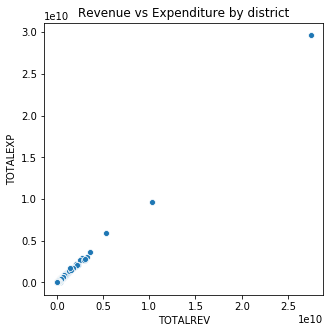

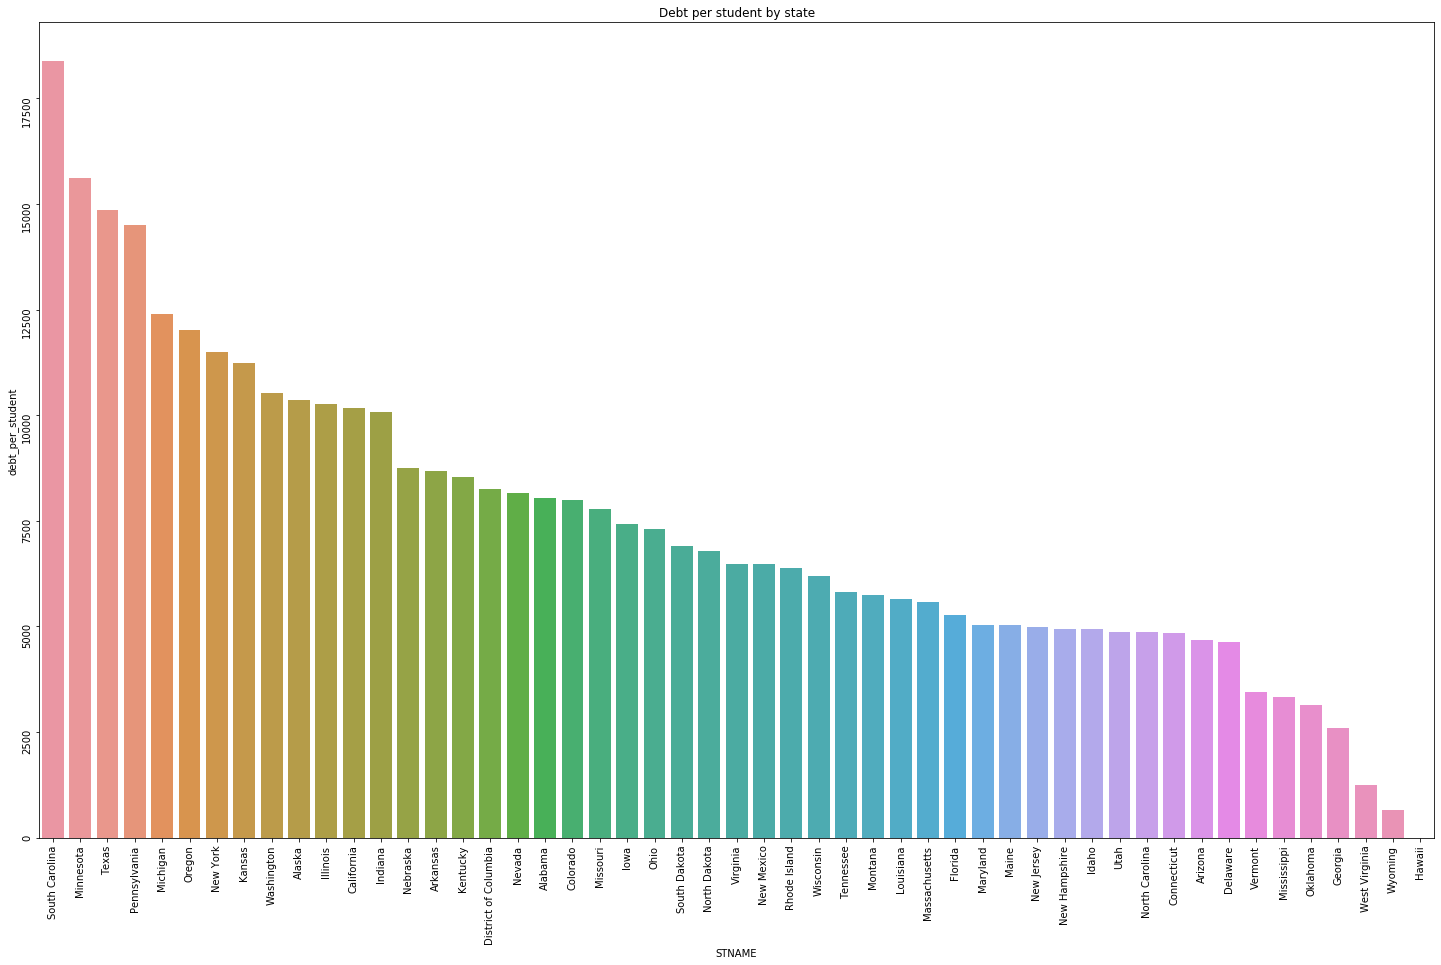

In [12]:
run2(fiscal_df)

### Problem 3

The district-level performance metrics from EDFacts may be useful in your decision. However, to protect student privacy, the data in these datasets has been heavily “blurred” to prevent students from being identified. Therefore, most of the numeric metrics are presented as ranges in string format. In addition, censored and missing data must be imputed.

Write and explain a function for processing a single column of “blurred” metrics into usable numeric values. Use it to process and then visualize the distribution of a performance metric of your choice.

In [17]:
def unblur_column(math_df, column_name):
    column_new_values = []
    column_old_values = math_df[column_name]
#     column_old_values = ['42', '45-49', 'LT50', 'LE20', 'GT20', 'GE50']
    for value in column_old_values:
        new_value = None
        if '-' in value:
            value_array = value.split('-')
            new_value = random.randint(int(value_array[0]), int(value_array[1]))
        elif 'LT' in value:
            begin = 0
            end = int(value[2:])
            new_value = random.randrange(begin, end)
        elif 'LE' in value:
            begin = 0
            end = int(value[2:])
            new_value = random.randint(begin, end)
        elif 'GT' in value:
            begin = int(value[2:]) + 1
            end = 100
            new_value = random.randint(begin, end)
        elif 'GE' in value:
            begin = int(value[2:])
            end = 100
            new_value = random.randint(begin, end)
        elif 'PS' in value:
            new_value = random.randint(0, 100)
        else:
            new_value = int(value)
        column_new_values.append(new_value)
    return column_new_values

In [18]:
def run_3(math_df):
    column_name = 'ALL_MTH00PCTPROF_1516'
    column_new_values = unblur_column(math_df, column_name)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    sns.distplot(column_new_values, ax=ax)
    ax.title.set_text('Distribution of column: {} after unblur'.format(column_name))
    fig.savefig('../output/3_1.png')
    plt.show()

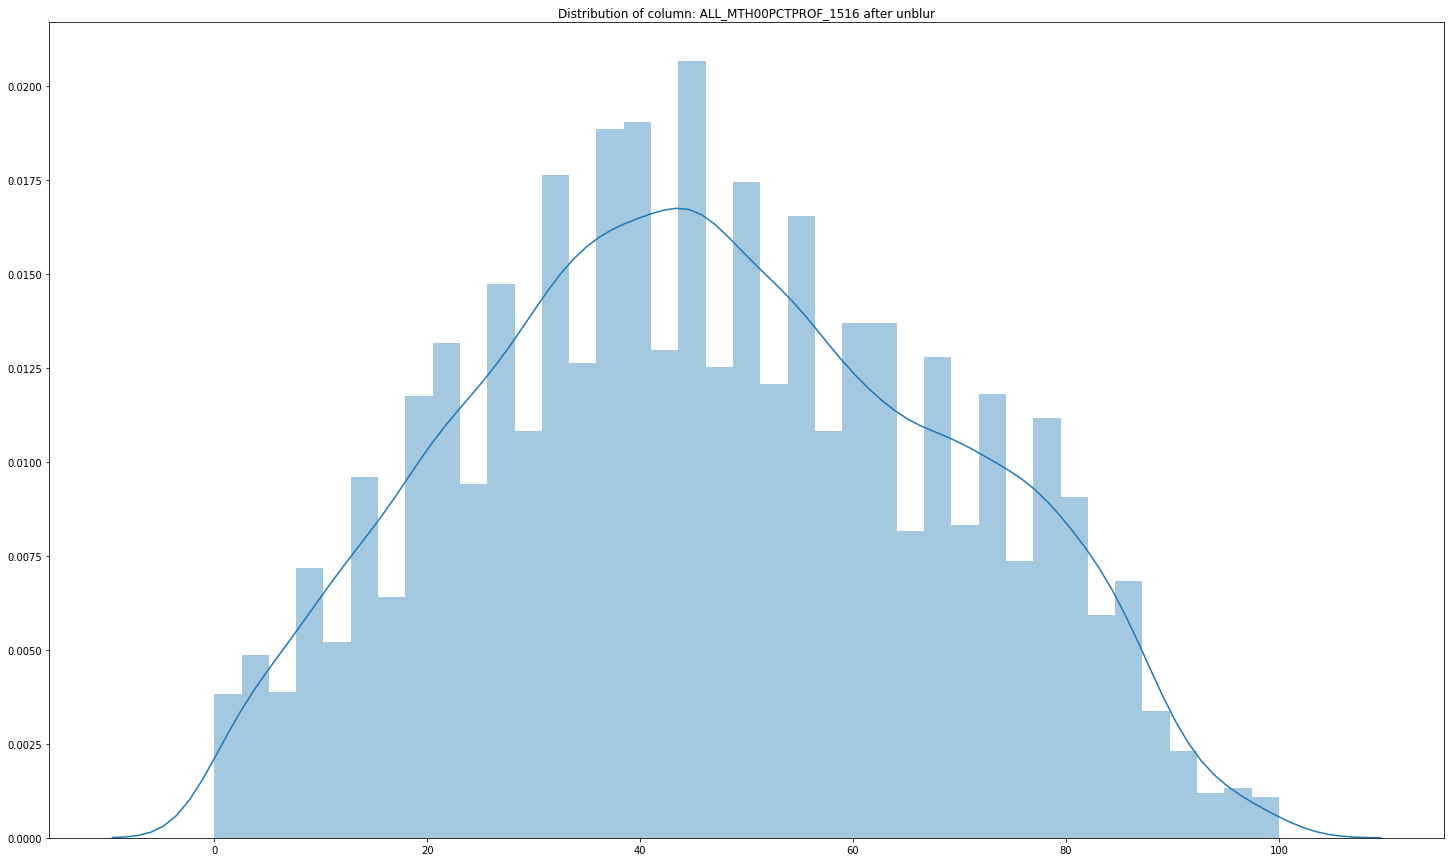

In [19]:
run_3(math_df)

### Problem 4

You are tasked with cutting 15% of the U.S. federal budget currently being spent on funding school districts. How much money is this?

Choose which school districts will have their funding cut and how this will be done. (You should produce a table of LEA IDs and the dollar amount by which their federal funding will be cut – you do not need print the entire table.)

In [20]:
def run_4_1(fiscal_df):
    sum_value = fiscal_df[['TFEDREV']].sum().values
    result = sum_value * 0.15
    return result

In [21]:
def run_4_2(fiscal_df, math_df, fifteen_percent_fed_budget):
    # Get the schools based on the criteria
    input_df = math_df[['LEAID', 'ALL_MTH00PCTPROF_1516']]
    input_df['ALL_MTH00PCTPROF_1516'] = unblur_column(math_df, 'ALL_MTH00PCTPROF_1516')
    
    # Get the 75 percent quartile as the cutoff criteria
    seventy_five_percent_quantile = input_df['ALL_MTH00PCTPROF_1516'].quantile(.75)
    filtered_df = input_df[input_df['ALL_MTH00PCTPROF_1516']<seventy_five_percent_quantile]

    # Get the lead_ids for which budget has been approved
    approved_lead_ids = list(filtered_df['LEAID'].unique())
    result_df = fiscal_df[fiscal_df['LEAID'].isin(approved_lead_ids)][['LEAID', 'NAME', 'TFEDREV']]
    result_df['percentage_cut'] = result_df['TFEDREV']/result_df['TFEDREV'].sum()
    result_df['cut_amount'] = result_df['percentage_cut'] * fifteen_percent_fed_budget
    result_df.sort_values(by='cut_amount', ascending=True, inplace=True)
    
    return result_df

In [22]:
def run_4(fiscal_df, math_df):
    fifteen_percent_fed_budget = run_4_1(fiscal_df)
    print("15 percent of federal budget is: {}".format(fifteen_percent_fed_budget))
    result_df = run_4_2(fiscal_df, math_df, fifteen_percent_fed_budget)
    print(result_df)

In [23]:
run_4(fiscal_df, math_df)

15 percent of federal budget is: [8.3404113e+09]
         LEAID                          NAME     TFEDREV  percentage_cut  \
6230   2313590    Westmanland Public Schools        1000    5.618962e-08   
7027   2601042            Branch Line School        1000    5.618962e-08   
727     400931           ECA - Arizona  Inc.        2000    1.123792e-07   
6794   2600121  Honey Creek Community School        2000    1.123792e-07   
9157   3004920                 Broadview H S        3000    1.685689e-07   
...        ...                           ...         ...             ...   
7232   2612000  Detroit City School District   193905000    1.089545e-02   
15635  4700148                 Shelby County   212572000    1.194434e-02   
15038  4218990          Philadelphia City SD   271369000    1.524812e-02   
9784   3200060  CLARK COUNTY SCHOOL DISTRICT   277628000    1.559981e-02   
1904    622710           Los Angeles Unified  1091400000    6.132535e-02   

         cut_amount  
6230   4.686446e

/Users/karangm/PycharmProjects/ds5500-hw3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Problem 5
Provide a statement for your supervisor justifying your decisions on which school districts will lose funding

The criteria for chosing for federal budget cut was the 75 percentile of ALL_MTH00PCTPROF_1516. 

Whichever school falls below the 75th percentile, that school will have budget cut of approximatelely (Federal_Revenue_of_that_school)/(Sum of Federal revenue of all candidate schools) * (15 percent of total federal revenue)